### Regression with Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats.mstats import winsorize

In [2]:
df=pd.read_csv('../appliances-energy.csv')
df.head(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [3]:
#Due to lot of zero enteries, this column is of not much use and will be ignored in rest of the model.
df.drop(columns='lights',axis=1,inplace=True)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df= df.set_index('date')
df.index.name ='time'
df['date'] = df.index.date
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour

In [5]:
df2=pd.concat([df.groupby(['month','day','hour']).Appliances.sum(),
           df.groupby(['month','day','hour']).mean().drop('Appliances',axis=1)],axis=1)

In [6]:
def f(x):
    x = x +273.15
    return x

In [7]:
dfk=df2.copy()
temp_list=['T1','T2','T3','T4','T6','T5','T7','T8','T9','T_out','Tdewpoint']
for i in temp_list:
    dfk[i] = dfk[i].apply(f)

In [8]:
dfkw=pd.DataFrame()
others=['RH_4','RH_6','T7']
for i in others:
    dfkw['w_%s'%i]=dfk[i]

In [9]:
#One by one, we kept winsorization low ratio because it might cause some side effects if we increase that ratio too much.
dfkw['w_Appliances']=winsorize(dfk.Appliances,(0,0.105))
dfkw['w_T1']=winsorize(dfk.T1,(0.05,0.05))
dfkw['w_RH_1']=winsorize(dfk.RH_1,(0.01,0.01))
dfkw['w_T2']=winsorize(dfk.T2,(0,0.04))
dfkw['w_RH_2']=winsorize(dfk.RH_2,(0.01,0.01))
dfkw['w_T3']=winsorize(dfk.T3,(0,0.02))
dfkw['w_T4']=winsorize(dfk.T4,(0.01,0.01))
dfkw['w_T5']=winsorize(dfk.T5,(0,0.01))
dfkw['w_RH_5']=winsorize(dfk.RH_5,(0.001,0.07))
dfkw['w_T6']=winsorize(dfk.T6,(0,0.05))
dfkw['w_RH_7']=winsorize(dfk.RH_7,(0,0.04))
dfkw['w_T_out']=winsorize(dfk.T_out,(0,0.04))
dfkw['w_Press_mm_hg']=winsorize(dfk.Press_mm_hg,(0.012,0))
dfkw['w_RH_out']=winsorize(dfk.RH_out,(0.02,0))
dfkw['w_Windspeed']=winsorize(dfk.Windspeed,(0,0.02))
dfkw['w_Visibility']=winsorize(dfk.Visibility,(0.05,0.125))
dfkw['w_RH_3']=winsorize(dfk.RH_3,(0,0.001))
dfkw['w_T8']=winsorize(dfk.T8,(0.05,0))
dfkw['w_RH_8']=winsorize(dfk.RH_8,(0,0.01))
dfkw['w_T9']=winsorize(dfk.T9,(0,0.001))
dfkw['w_RH_9']=winsorize(dfk.RH_9,(0.001,0.001))
dfkw['w_Tdewpoint']=winsorize(dfk.Tdewpoint,(0,0.001))
dfkw['w_rv1']=winsorize(dfk.rv1,(0.005,0.005))
dfkw['w_rv2']=winsorize(dfk.rv2,(0.005,0.005))

In [10]:
df3=dfkw.copy()
dflog=pd.DataFrame()
for col in df3.columns:
    dflog['log_%s'%col]=np.log(df3[col])

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dflog)
min_max=scaler.transform(dflog)
scale_df=pd.DataFrame(min_max)
scale_df=scale_df.rename({0:'Appliances'},axis=1)

In [40]:
#Train-test split
from sklearn.model_selection import train_test_split
X = scale_df.drop('Appliances',axis=1)
y = scale_df.Appliances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

In [41]:
# Decision Tree Algorithm with GridSearchCV

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
parameter={'max_depth':range(2,12),'min_samples_split' : range(1,20,5),"min_samples_leaf":range(1,10)}
d_tree=DecisionTreeRegressor()
dtgrd=GridSearchCV(d_tree,parameter,cv=10)
model=dtgrd.fit(X_train,y_train)

In [61]:
# examine the best model
print('Best Estimator:', model.best_estimator_)
print('Best Score:', model.best_score_)

Best Estimator: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=11,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Best Score: 0.9373167808574167


In [62]:
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score
model=model.best_estimator_.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(model.score(X_test,y_test))
print(model.score(X_train,y_train))

0.9430697053489664
0.9849864204868735


In [64]:
from sklearn.metrics import mean_squared_error as MSE
mse_dtree=MSE(y_pred,y_test)
rmse_dtree=mse_dtree**(1/2)
print("Root Mean Squared Error value of Decision Tree:",round(rmse_dtree,5))

Root Mean Squared Error value of Decision Tree: 0.04666


### Classification with Decision Tree

In [74]:
telco=pd.read_csv('../telco_customer_churn.csv')
telco.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [75]:
telco.dropna(inplace=True)
telco=telco.drop(['customerID'],axis=1)
target=['Churn']
categorical=telco.select_dtypes(include='object').columns.tolist()
categorical=[x for x in categorical if x not in target]
numeric=telco.dtypes[telco.dtypes!=object].keys().tolist()

In [76]:
telco.Churn=telco.Churn.replace({"Yes":1, "No":0})
telco2=pd.concat([telco,pd.get_dummies(telco[categorical])],axis=1).drop(telco[categorical],axis=1)

In [77]:
X=telco2.drop('Churn',axis=1)
y=telco2.Churn

In [122]:
from sklearn.preprocessing import StandardScaler
#Instantiate the scaler
scaler=StandardScaler()
Xsc=scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(Xsc,y,test_size=0.20, random_state=40,stratify = y)

In [123]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier(criterion="entropy",max_depth=10)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [124]:
from sklearn.metrics import roc_auc_score
y_predct=dtc.predict(X_test)
dt_probs=dtc.predict_proba(X_test)[:,1]

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary and it’s imbalanced data set classification problem. AUC is a good way for evaluation for this type of problems.

AUC Score: 0.7929538350254461


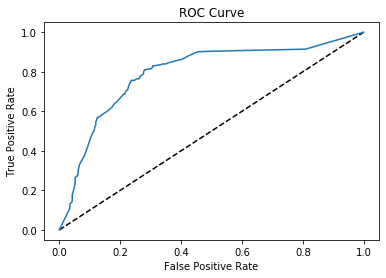

In [125]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds  = roc_curve(y_test, dt_probs)
import matplotlib.pyplot as plt
print("AUC Score:",metrics.roc_auc_score(y_test, dt_probs))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [126]:
# Also lets see confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test,y_predct)
print("Confusion Matrix (Test Data)", confusion_matrix_test, sep="\n")
print("\nF1 Score(Test):",metrics.f1_score(y_test,y_predct))

Confusion Matrix (Test Data)
[[905 130]
 [161 213]]

F1 Score(Test): 0.5941422594142259


In [112]:
# Decision Tree's auc score is 0.79 and KNeighbors' auc score was 0.66 before study for the same dataset. 
# Decision Tree is better than KKNeighbors Algorithm for this dataset.